# Exploratory Data Analysis (EDA) for Soccer Substitution Simulation

This notebook performs exploratory data analysis on the synthetic soccer substitution simulation dataset. It pairs with `00_simulation.py` from the same project.

## Goals

1. Load or generate the simulated dataset
2. Produce summary statistics and distribution plots for key features and outcomes
3. Quantify naïve vs. adjusted estimates of substitution impact on shots to motivate the causal analysis step
4. Save figures and simple CSV summaries for easy inclusion in reports or dashboards

## 1. Imports and Setup

In [1]:
from __future__ import annotations

import pathlib
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from causalai.simulation import simulate_matches

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
seed = sum(map(ord, "eda-simulation"))
rng = np.random.default_rng(seed)

## 2. Configuration

Set up the parameters for data generation or loading. You can modify these values as needed.

In [3]:
# Configuration parameters
N_MATCHES = 10000  # Number of matches to simulate
CSV_PATH = None  # Path to existing CSV file (None to simulate fresh data)
OUTPUT_DIR = pathlib.Path("eda_outputs")  # Directory to save outputs

## 3. Data Loading and Simulation

Load existing data from CSV or simulate fresh data based on the configuration.

In [4]:
def load_or_simulate(n: int, seed: int, csv_path: Optional[pathlib.Path] = None) -> pd.DataFrame:
    """
    Load a dataset from CSV or simulate a fresh one.

    Args:
        n: Number of matches to simulate if no CSV provided
        seed: Random seed for reproducibility
        csv_path: Path to existing CSV file, or None to simulate

    Returns:
        DataFrame with the soccer match data
    """
    if csv_path and csv_path.exists():
        print(f"Loading data from {csv_path}")
        return pd.read_csv(csv_path)
    print(f"Simulating dataset with n={n}, seed={seed}")
    return simulate_matches(n_matches=n, seed=seed)

In [5]:
df = load_or_simulate(n=N_MATCHES, seed=seed, csv_path=CSV_PATH)

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Simulating dataset with n=10000, seed=1436

Dataset shape: (10000, 17)
Columns: ['off_old', 'def_old', 'score_diff', 'sub', 'off_new', 'def_new', 'shots', 'goals', 'passes', 'tackles', 'clearances', 'blocks', 'pressures', 'dribbles', 'saves', 'fouls', 'cards']


off_old    def_old  score_diff  sub    off_new    def_new  shots  goals  \
0  59.829088  50.311367           1    0  59.829088  50.311367      7      1   
1  66.932724  55.248509           1    0  66.932724  55.248509      6      1   
2  45.705586  52.293501           0    1  52.311915  45.083977      5      2   
3  33.402367  39.559093           0    1  39.212239  33.273649      6      0   
4  47.139818  49.026986          -1    0  47.139818  49.026986      3      1   

   passes  tackles  clearances  blocks  pressures  dribbles  saves  fouls  \
0      68        6           3       3          6         7      4      1   
1      70        4           5       6          4         8      4      0   
2      40        5           9       2          4         1      3      1   
3      36        2           2       1          4         1      2      0   
4      39        4           1       3          2         6      2      0   

   cards  
0      0  
1      0  
2      0  
3      0  
4      0

## 4. Basic Summary Statistics

Generate descriptive statistics for all variables in the dataset.

In [6]:
df.describe().T.round(2)

count   mean    std    min    25%    50%    75%     max
off_old     10000.0  55.07  10.10  13.41  48.09  54.96  61.91   91.91
def_old     10000.0  54.94   7.13  28.86  50.10  54.92  59.65   83.58
score_diff  10000.0   0.20   0.83  -3.00   0.00   0.00   1.00    3.00
sub         10000.0   0.50   0.50   0.00   0.00   1.00   1.00    1.00
off_new     10000.0  57.00   9.96  13.41  50.21  56.86  63.82   97.42
def_new     10000.0  53.04   8.43  20.54  47.25  53.01  58.83   83.58
shots       10000.0   6.15   2.75   0.00   4.00   6.00   8.00   19.00
goals       10000.0   0.92   0.97   0.00   0.00   1.00   1.00    6.00
passes      10000.0  55.93  12.70  15.00  47.00  55.00  64.00  109.00
tackles     10000.0   5.73   2.67   0.00   4.00   5.00   7.00   17.00
clearances  10000.0   4.85   2.57   0.00   3.00   5.00   6.00   19.00
blocks      10000.0   3.04   1.97   0.00   2.00   3.00   4.00   15.00
pressures   10000.0   6.60   2.72   0.00   5.00   6.00   8.00   23.00
dribbles    10000.0   3.65   2.05   0.00   2.00   3.00   5.00   14.00
saves       10000.0   4.19   2.33   0.00   2.00   4.00   6.00   16.00
fouls       10000.0   0.76   0.89   0.00   0.00   1.00   1.00    6.00
cards       10000.0   0.08   0.28   0.00   0.00   0.00   0.00    2.00

## 5. Distribution Analysis

Plot histograms and distributions for key performance metrics to understand the data structure.

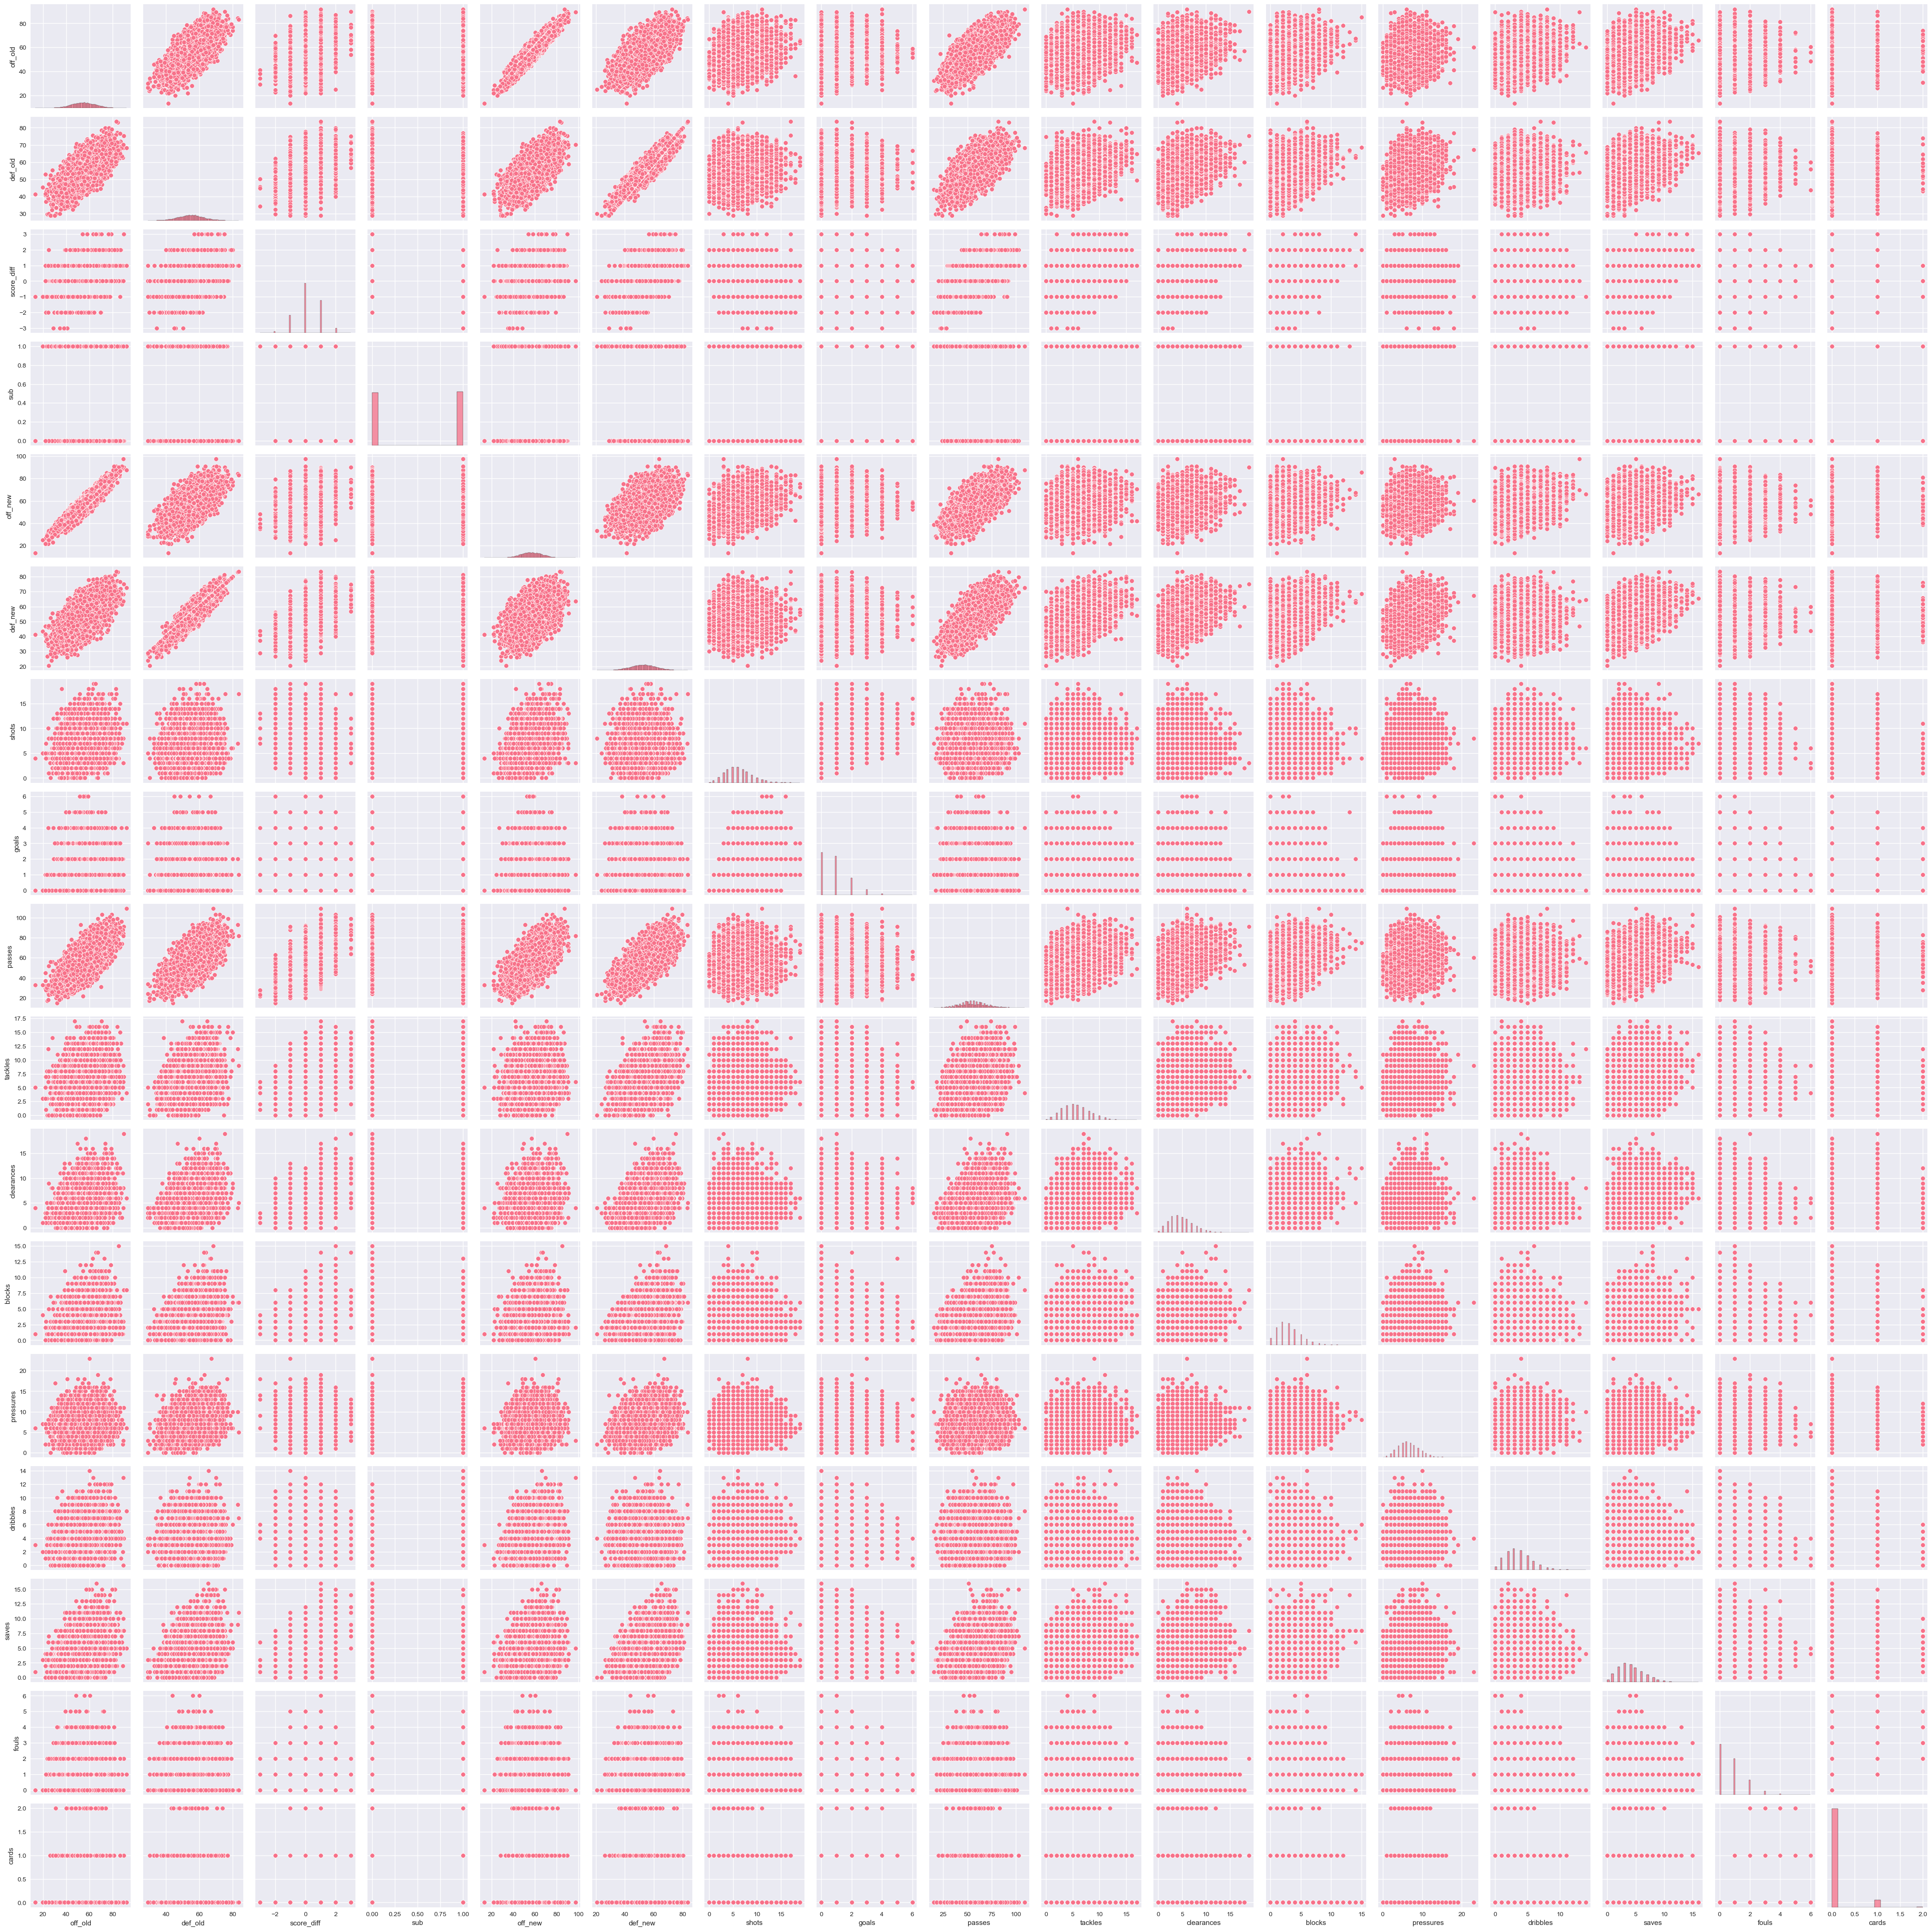

In [ ]:
# FROM THIS CELL ON, ADD WHAT'S USEFUL IN THERE TO CAUSAL_EDA.IPYNB

g = sns.PairGrid(df)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot);

## 6. Substitution Effect Analysis

Compare naïve vs. score-difference adjusted estimates of substitution impact on shots. This analysis demonstrates why causal inference is necessary.

In [ ]:
def plot_naive_vs_adjusted(df: pd.DataFrame, outdir: pathlib.Path) -> None:
    """
    Compare naïve vs. score‐diff adjusted effect of substitutions on Shots.

    Args:
        df: Input DataFrame
        outdir: Directory to save plots
    """
    outdir.mkdir(parents=True, exist_ok=True)

    # Naïve difference
    mean_shots_sub = df.loc[df["T"] == 1, "Shots"].mean()
    mean_shots_no_sub = df.loc[df["T"] == 0, "Shots"].mean()
    naive_diff = mean_shots_sub - mean_shots_no_sub

    # Adjusted for score_diff using simple group means
    grouped = df.groupby(["T", "score_diff"])["Shots"].mean().unstack(0)
    adjusted_diff = (grouped[1] - grouped[0]).mean()

    # Print results
    print(f"Naïve difference in shots (Sub - No Sub): {naive_diff:.3f}")
    print(f"Adjusted difference in shots (Sub - No Sub): {adjusted_diff:.3f}")
    print(f"Difference between naïve and adjusted: {naive_diff - adjusted_diff:.3f}")

    # Bar plot
    plt.figure(figsize=(8, 6))
    bars = plt.bar(
        ["Naïve", "Adjusted"],
        [naive_diff, adjusted_diff],
        color=["lightcoral", "lightblue"],
    )
    plt.ylabel("Δ Shots (Sub − No Sub)")
    plt.title("Naïve vs. Score‐Adjusted Impact of Substitution on Shots")

    # Add value labels on bars
    for idx, diff in enumerate([naive_diff, adjusted_diff]):
        plt.text(idx, diff + 0.02, f"{diff:.3f}", ha="center", va="bottom", fontweight="bold")

    plt.grid(axis="y", alpha=0.3)
    plt.savefig(outdir / "naive_vs_adjusted_shots.png", dpi=300, bbox_inches="tight")
    plt.show()


# Analyze substitution effects
plot_naive_vs_adjusted(df, OUTPUT_DIR)
print("\nNaïve vs. adjusted effect plot saved to output directory.")

## 7. Additional Exploratory Analysis

Let's explore some additional relationships in the data to better understand the substitution effects.

In [ ]:
# Substitution rate by score difference
sub_rate_by_score = df.groupby("score_diff")["T"].mean()

plt.figure(figsize=(10, 6))
sub_rate_by_score.plot(kind="bar")
plt.title("Substitution Rate by Score Difference")
plt.xlabel("Score Difference")
plt.ylabel("Substitution Rate")
plt.xticks(rotation=45)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "substitution_rate_by_score.png", dpi=300, bbox_inches="tight")
plt.show()

print("Substitution rates by score difference:")
print(sub_rate_by_score)

In [ ]:
# Correlation matrix of key variables
key_vars = [
    "Shots",
    "Goals",
    "Passes",
    "Tackles",
    "Clearances",
    "Pressures",
    "T",
    "score_diff",
]
correlation_matrix = df[key_vars].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

print("\nCorrelation matrix saved to output directory.")

## 8. Summary and Next Steps

This EDA has revealed important insights about the soccer substitution simulation data:

### Key Findings:
1. **Data Structure**: We have a comprehensive dataset with various performance metrics
2. **Substitution Patterns**: Substitution rates vary by score difference
3. **Naïve vs. Adjusted Effects**: There's a difference between naïve and score-adjusted estimates of substitution impact

### Files Generated:
- Summary statistics CSV
- Distribution plots for all metrics
- Naïve vs. adjusted effect comparison
- Substitution rate analysis
- Correlation matrix

### Next Steps:
The difference between naïve and adjusted estimates suggests that confounding variables (like score difference) may be affecting the relationship between substitutions and performance. This motivates the need for causal inference methods to properly estimate the true causal effect of substitutions on team performance.